### The Stationarity vs Memory Dilemma

In finance, we often encounter non-stationary time series. These time series are non-stationary because they contain memory - that is, the long history of past values causes the mean of the series to change over time. When researchers perform inference analysis, they need to work with stationary processes such as price returns, bond yield changes, and volatility changes, which do not vary over time. This type of data transformation makes the time series stationary but also eliminates all memory in the original time series. Although stationarity is necessary for inference purposes, from a signal processing perspective, we don't want all memory to disappear. This is because memory forms the basis of model prediction accuracy.

For example, if we want to use a stationary model to predict how far a price process deviates from its long-term expected price, some level of memory is required. The problem is that returns are memoryless and stationary, while price data has memory and is non-stationary. The question is: What is the smallest differencing order that can make a price time series stationary while preserving as much memory as possible? By generalizing the concept of differencing, we consider a stationary time series where the entire memory is not erased. In this framework, we realize that returns are just one of many possible ways to transform prices.

One reason cointegration is important is that it allows modeling of time series while preserving memory. However, why does the special case of zero-order differencing produce the best results? Zero-order differencing is as arbitrary as first-order differencing. There is a large gap between these two differencing orders, and to build a machine learning model with high predictive power, we must explore this gap through fractional calculus.

Supervised learning algorithms typically require the assumption of stationarity. This is because, in order to map a set of labeled examples from test data, it is necessary to infer labels for new observations. If the features do not follow the stationarity assumption, we cannot map new observations to a large set of known examples. However, stationarity does not guarantee predictive power. Stationarity is a necessary but not sufficient condition for high-performance machine learning algorithms. The problem lies in the trade-off between stationarity and memory. Differencing can make a series stationary, but the more differencing performed, the more memory is erased, which compromises the predictive purpose of the machine learning algorithm. This chapter explores methods for resolving this dilemma.

### Methodology

Let's assume a backshift operator $B$ applied to a real-valued feature $\{X_t\}$. For all integers $k \geq 0$, we have $B^k X_t = X_{t-k}$. Notice the binomial expansion for positive integer $n$:

$$(x + y)^n = \sum_{k=0}^n {n \choose k} x^k y^{n-k} = \sum_{k=0}^n {n \choose k} x^{n-k} y^k$$

For real number $d$, the binomial expansion is:

$$(1 + x)^d = \sum_{k=0}^\infty {d \choose k} x^k$$

In a Fractionally Differentiated model, the exponent $d$ is a real number, and the binomial expansion follows the form:

$$(1-B)^d = \sum_{k=0}^\infty {d \choose k} (-B)^k = \sum_{k=0}^\infty \frac{\prod_{i=0}^{k-1}(d-i)}{k!}$$

$$= \sum_{k=0}^\infty (-B)^k \prod_{i=0}^{k-1} \frac{d-i}{k-i}$$

$$= 1 - dB + \frac{d(d-1)}{2!}B^2 - \frac{d(d-1)(d-2)}{3!}B^3 + \cdots$$

### Long Memory

Let's explore how a positive real number $d$ preserves memory. The following arithmetic series is internally generated:

$$
\tilde{X}_t = \sum_{k=0}^\infty \omega_k X_{t-k}
$$

Where the weights $\omega$ are given by:

$$
\omega = \left\{
1, -d, \frac{d(d-1)}{2!}, -\frac{d(d-1)(d-2)}{3!}, \cdots, (-1)^k \prod_{i=0}^{k-1} \frac{d-i}{k!}, \cdots
\right\}
$$

And the values of $X$ are:

$$
X = \{X_t, X_{t-1}, X_{t-2}, X_{t-3}, \dots, X_{t-k}, \dots\}
$$

When $d$ is a positive integer, $\prod_{i=0}^{k-1} \frac{d-i}{k!} = 0 \, \forall k > d$, and market memory beyond this point disappears. For instance, when $d = 1$, the differencing coefficients used to calculate returns are:

$$
\prod_{i=0}^{k-1} \frac{d-i}{k!} = 0 \, \forall k > 1
$$

Thus, $\omega = \{1, -1, 0, 0, \dots\}$.

### Iterative Estimation

Looking at the sequence of weights $\omega$, we see that $\omega_0 = 1$, and for $k = 0, \dots, \infty$, the weights are iteratively generated as:

$$
\omega_k = -\omega_{k-1} \frac{d-k+1}{k}
$$

The following graph represents the sequence of weights used to calculate the values of each fractional differenced series. The legend shows the value of $d$ used to generate each sequence, with the x-axis representing $k$ and the y-axis representing $\omega_k$. For example, when $d = 0$, all weights are zero except for $\omega_0 = 1$ and $\omega_1 = -1$, which are used to compute the log price returns via standard first differencing. In between these two cases, $\omega_0 = 1$, followed by all negative weights larger than -1.


### Literature Review



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_weights(d, size) :
    # thres > 0 유의미하지 않은 가중값을 제거
    w = [1.]
    for k in range(1, size) :
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

def plot_weights(d_range, n_plots, size, ax) :
    w = pd.DataFrame()
    for d in np.linspace(d_range[0], d_range[1], n_plots) :
        w_ = get_weights(d, size)
        w_ = pd.DataFrame(w_, index = range(w_.shape[0])[::-1], columns = [d])
        w = w.join(w_, how = 'outer')
    w.plot(ax = ax)
    return None

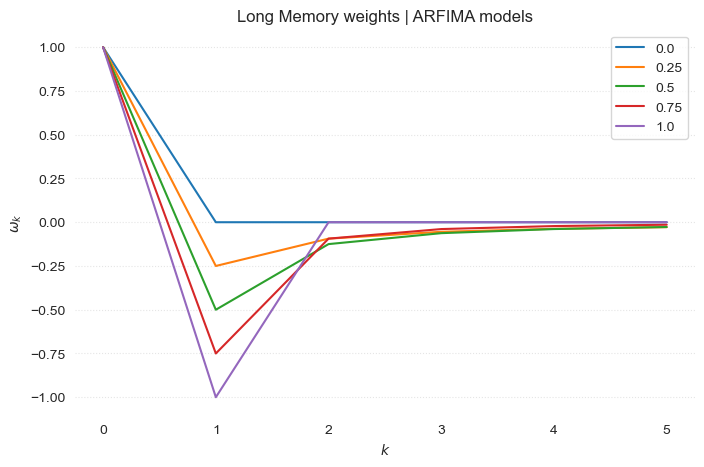

In [2]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_weights(
    d_range = [0, 1], 
    n_plots = 5, 
    size = 6,
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel(r'$k$')
plt.ylabel(r'$\omega_k$')
plt.title('Long Memory weights | ARFIMA models')
plt.show()

아래의 그림은 $d \in [1, 2]$의 가중값 시퀀스를 0.25씩 증가시키며 그린 것이다. $d > 1$에 대해서 $\omega_1 < -1$이고 $\omega_k > 0$, $\forall k \geq 2$라는 것을 관찰할 수 있다.

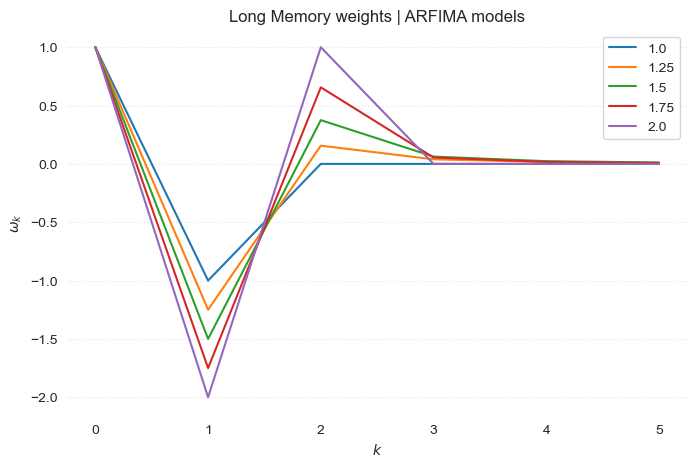

In [3]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_weights(
    d_range = [1, 2], 
    n_plots = 5, 
    size = 6,
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel(r'$k$')
plt.ylabel(r'$\omega_k$')
plt.title('Long Memory weights | ARFIMA models')
plt.show()

### Convergence

Now, let's consider the convergence of the weights. From the previous results, for $k > d$, if $\omega_{k-1} \neq 0$, then 

$$
\left| \frac{\omega_k}{\omega_{k-1}} \right| = \left| \frac{d-k+1}{k} \right| < 1
$$

and if this condition is not satisfied, then $\omega_k = 0$. As a result, the weights asymptotically converge to 0, which is the infinite product of factors within the unit circle. Additionally, for positive $d$ and $k < d + 1$, we have $\frac{d-k+1}{k} \geq 0$, which causes the sign of the initial weights to alternate. For non-integer $d$, when $k \geq d + 1$, $\omega_k$ will be negative if $\mathrm{int}(d)$ is even, and positive if it is odd.

In summary, when $\mathrm{int}(d)$ is even, 

$$
\lim_{k \rightarrow \infty} \omega_k = 0^{-}
$$

and when $\mathrm{int}(d)$ is odd,

$$
\lim_{k \rightarrow \infty} \omega_k = 0^{+}.
$$

In the special case where $d \in (0,1)$, this means $ -1 < \omega_k < 0, \forall k > 0$. The alternating sign of these weights is necessary to make $\{ \tilde{X}_t \}_{t = 1, \dots, T}$ stationary, as the memory is gradually counteracted and decays over time.

### Implementation

In this section, we explore two methods for implementing fractional differentiation: one is the standard expanding window method, and the other is a new method called the fixed-width window fracdiff.

#### Expanding window



In [1]:
import statsmodels.api as sm
import yfinance as yf

start_date = '2000-01-01'
end_date = '2024-09-15'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date,
    progress = False,
    interval = '1d'
)

### Stationarity with Maximum Memory Preservation

Consider the time series $\{X_t\}_{t=1, \dots, T}$. When applying a fixed-width window fractional differencing method to this series, we can determine the minimum differencing coefficient $d^*$ that makes the fractional differenced series $\{\tilde X_t\}_{t=l^*, \dots, T}$ stationary. This coefficient quantifies the amount of memory that must be removed to achieve stationarity. If $\{\tilde X_t\}_{t=l^*, \dots, T}$ is already stationary, then $d^* = 0$.

If $\{\tilde X_t\}_{t=l^*, \dots, T}$ has a unit root, then $d^* < 1$. If $\{\tilde X_t\}_{t=l^*, \dots, T}$ exhibits explosive behavior, then $d^* > 1$. In the case where $0 < d^* < 1$, the raw series exhibits slight non-stationarity. In this case, differencing is needed to achieve stationarity; however, performing first differencing would remove meaningful market memory and signals embedded in the raw series.

### ADF


The Augmented Dickey-Fuller (ADF) test is used to test for stationarity in time series. The test is based on the following regression model:

$\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^{p} \delta_i \Delta y_{t-i} + \epsilon_t$

Where:
- $\Delta y_t = y_t - y_{t-1}$ is the first difference
- $\alpha$ is a constant term
- $\beta t$ is a time trend term
- $\gamma$ is the coefficient on the lagged level term
- $p$ is the number of lagged difference terms
- $\epsilon_t$ is the error term

The null hypothesis is $H_0: \gamma = 0$ (unit root exists, series is non-stationary)
The alternative hypothesis is $H_1: \gamma < 0$ (no unit root, series is stationary)

The ADF test statistic is calculated as:

$ADF = \frac{\hat{\gamma}}{SE(\hat{\gamma})}$

Where $\hat{\gamma}$ is the estimated coefficient and $SE(\hat{\gamma})$ is its standard error. The test compares this statistic to critical values to determine if we can reject the null hypothesis of non-stationarity.

In [4]:
from quant_free.finml.features.fracdiff import FractionalDifferentiatedFeatures

cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0, 1, 21):
    try:
        df1 = data[['Adj Close']]
        df2 = FractionalDifferentiatedFeatures.fracDiff(df1, d = d, thres = 1e-5)
        corr = np.corrcoef(df1.loc[df2.index,'Adj Close'], df2['Adj Close'])[0,1]
        df2 = sm.tsa.stattools.adfuller(df2['Adj Close'], maxlag = 1, regression = 'c', autolag = None)
        out.loc[round(d, 2)] = list(df2[:4]) + [df2[4]['5%']] + [corr]
    except Exception as e:
        print(f'd: {round(d, 2)}, error: {e}')
        continue

/opt/quantfree/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/quantfree/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/quantfree/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


d: 0.05, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.1, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.15, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.2, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.25, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


/opt/quantfree/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/quantfree/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/quantfree/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/quantfree/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/quantfree/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/quantfree/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/quantfree/lib/python3

In [6]:
out

,adfStat,pVal,lags,nObs,95% conf,corr
0.00,2.242975,9.989160e-01,1.0,6211.0,-2.862005,1.000000
0.30,-0.844250,8.057774e-01,1.0,5.0,-3.929280,0.946426
0.35,-1.868119,3.472041e-01,1.0,8.0,-3.367187,0.798552
0.40,-1.910402,3.271834e-01,1.0,13.0,-3.127149,0.890893
0.45,-2.050366,2.649349e-01,1.0,20.0,-3.021645,0.734982
0.50,-2.416678,1.370843e-01,1.0,32.0,-2.957219,0.679708
0.55,-2.936267,4.129030e-02,1.0,51.0,-2.920142,0.606241
0.60,-4.141210,8.272811e-04,1.0,83.0,-2.897048,0.177223
0.65,-5.026855,1.963153e-05,1.0,137.0,-2.882878,0.429226
0.70,-6.874002,1.490610e-09,1.0,230.0,-2.874190,0.361979


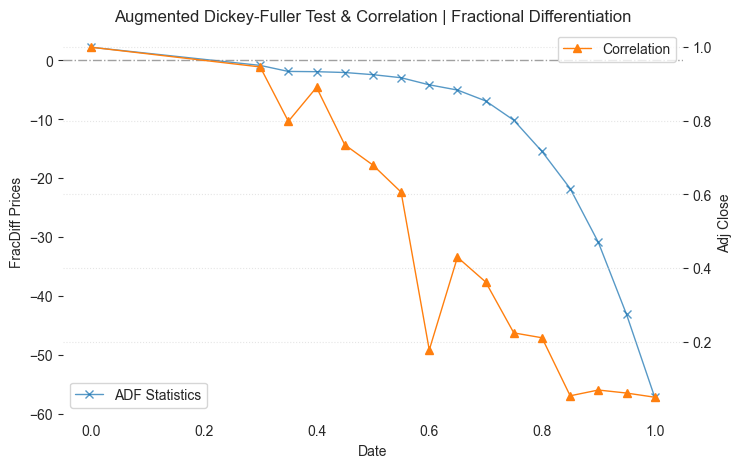

In [9]:
fig, ax1 = plt.subplots(figsize = (8, 5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('FracDiff Prices')
ax1.plot(out['adfStat'], color=color, alpha=0.75, lw=1, marker = 'x')
ax1.tick_params(axis='y')
ax1.legend(['ADF Statistics'])
ax1.axhline(0, color='gray', alpha=0.75, ls='-.', lw = 1)
ax1.grid(False)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Adj Close')
ax2.plot(out['corr'], color=color, lw=1, alpha=1, marker = '^')
ax2.legend(['Correlation'], loc='upper right')
ax2.tick_params(axis='y')

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Augmented Dickey-Fuller Test & Correlation | Fractional Differentiation')

plt.show()

In [7]:
frac_close = FractionalDifferentiatedFeatures.fracDiff(data[['Adj Close']], 0.55)

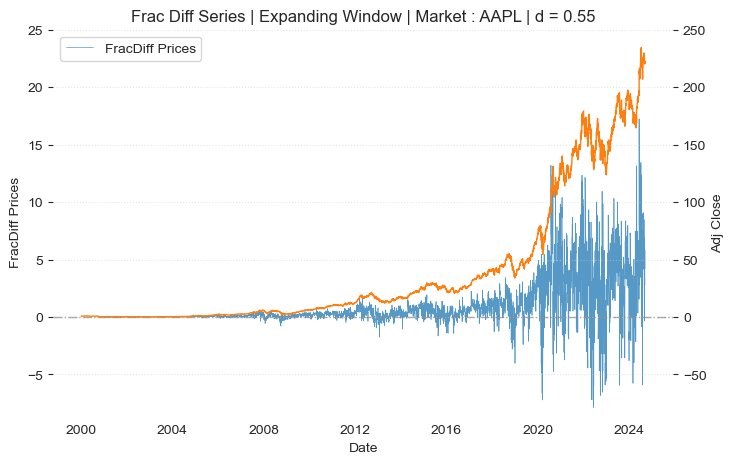

In [9]:
fig, ax1 = plt.subplots(figsize = (8, 5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('FracDiff Prices')
ax1.plot(frac_close['Adj Close'], color=color, alpha=0.75, lw=0.5)
ax1.tick_params(axis='y')
ax1.legend(['FracDiff Prices'], loc='upper left')
ax1.set_ylim([-8.5, 25])
ax1.axhline(0, color='gray', alpha=0.75, ls='-.', lw = 1)
ax1.grid(False)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Adj Close')
ax2.plot(data['Adj Close'], color=color, lw=1, alpha=1)
ax2.tick_params(axis='y')
ax2.set_ylim([-85, 250])

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Frac Diff Series | Expanding Window | Market : AAPL | d = 0.55')

plt.show()

In [10]:
frac_close_ffd = FractionalDifferentiatedFeatures.fracDiff_FFD(data[['Adj Close']], 0.55)

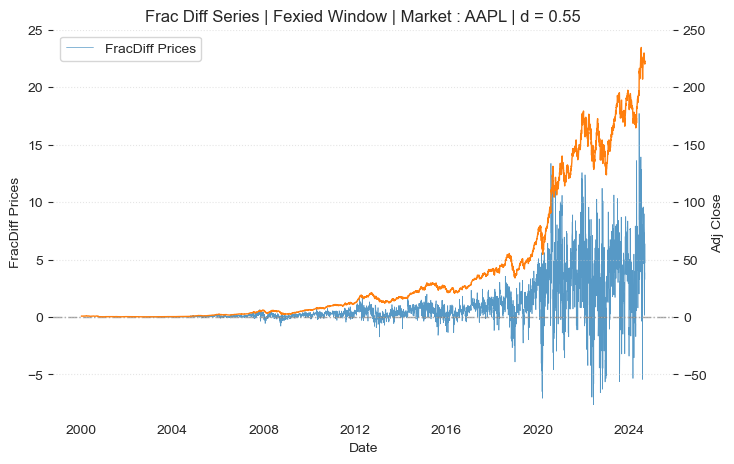

In [11]:
fig, ax1 = plt.subplots(figsize = (8, 5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('FracDiff Prices')
ax1.plot(frac_close_ffd['Adj Close'], color=color, alpha=0.75, lw=0.5)
ax1.tick_params(axis='y')
ax1.legend(['FracDiff Prices'], loc='upper left')
ax1.set_ylim([-8.5, 25])
ax1.axhline(0, color='gray', alpha=0.75, ls='-.', lw = 1)
ax1.grid(False)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Adj Close')
ax2.plot(data['Adj Close'], color=color, lw=1, alpha=1)
ax2.tick_params(axis='y')
ax2.set_ylim([-85, 250])

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Frac Diff Series | Fexied Window | Market : AAPL | d = 0.55')

plt.show()

In [12]:
from quant_free.finml.statsmodels_extension.arfima import ARFIMA

arfima = ARFIMA(data['Adj Close'], order = (10, 0.55, 9)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66801D+03    |proj g|=  3.33041D+03


 This problem is unconstrained.



At iterate    5    f=  1.70890D+00    |proj g|=  1.03372D-01

At iterate   10    f=  1.66345D+00    |proj g|=  2.47498D-02

At iterate   15    f=  1.65870D+00    |proj g|=  1.36263D-02

At iterate   20    f=  1.65829D+00    |proj g|=  4.09305D-03

At iterate   25    f=  1.65723D+00    |proj g|=  2.29149D-02

At iterate   30    f=  1.65707D+00    |proj g|=  4.57496D-03

At iterate   35    f=  1.65689D+00    |proj g|=  4.91067D-03

At iterate   40    f=  1.65593D+00    |proj g|=  8.78601D-02

At iterate   45    f=  1.65444D+00    |proj g|=  1.08406D-01

At iterate   50    f=  1.65336D+00    |proj g|=  2.11340D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [13]:
print(arfima.summary())

                           ARFIMA Results
Dep. Variable:   predicted               No. Observations: 5475     
Model:           ARFIMA(10, 0.55, 9)     Log Likelihood    -9052.153
Date:            Sun, 29 Sep 2024        AIC               18144.306
Time:            14:28:36                BIC               18276.465
Covariance Type: opg                     HQIC              18190.414
Sample:          12-12-2002 - 09-13-2024                            
----------------------------------------------------------------------
               coef    std err      t       P>|t|     [0.025    0.975]
----------------------------------------------------------------------
ar.L1        -1.0281    0.6044    -1.7010   0.0889   -2.2128    0.1565
ar.L2        -1.0748    0.1509    -7.1207   0.0000   -1.3707   -0.7790
ar.L3        -1.3169    0.5326    -2.4724   0.0134   -2.3609   -0.2730
ar.L4        -0.5091    0.3843    -1.3246   0.1853   -1.2624    0.2442
ar.L5         0.0555    0.0146     3.8126   0.0